In [1]:
import warnings
warnings.simplefilter("ignore")
import os
import sys
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
import tensorflow as tf
import time
import logging
tf.get_logger().setLevel(logging.ERROR)

import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fftfreq, fftshift, fftn
import matplotlib.pyplot as plt
from pylab import *

from utils import NeuralNet, create_ds, poisson

2025-03-12 14:25:59.293184: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
class MultistageNeuralNetwork:
    """
    MultistageNeuralNetwork is a multi-stage model used for predicting
    high-dimensional function outputs through regression. This class encapsulates
    the functionality for constructing, training, and predicting using a sequence
    of neural networks, where each stage of the network can focus on different
    aspects of the data.

    Attributes:
        dim (int): Dimensionality of the input data.
        N (int): Number of points per dimension in the dataset.
        stages (list): List of neural networks, one for each stage.
        layers (list): Architecture of the neural network (input layer, hidden layers, output layer).
        lt (list): Minimum values for each dimension in the input data.
        ut (list): Maximum values for each dimension in the input data.
    """

    def __init__(self, x_train, num_hidden_layers, num_hidden_nodes):
        """
        Initialize the MultistageNeuralNetwork instance.

        Args:
            x_train (tf.Tensor): Input training data.
            num_stages (int): Number of stages in the multi-stage neural network.
            num_hidden_layers (int): Number of hidden layers in each stage.
            num_hidden_nodes (int): Number of nodes in each hidden layer.
        """
        self.dim = x_train.shape[-1]                                 # Number of dimensions in the input data.
        self.N = int(round(x_train.shape[0] ** (1 / self.dim)))      # Number of points per dimension.
        # self.stages = [None] * num_stages                            # List to store each stage's neural network.
        self.stages = []
        self.layers = [self.dim] + ([num_hidden_nodes] * num_hidden_layers) + [1]  # Neural network architecture.
        self.lt = [tf.math.reduce_min(x_train[:, i]) for i in range(x_train.shape[-1])]  # Min values for each dimension.
        self.ut = [tf.math.reduce_max(x_train[:, i]) for i in range(x_train.shape[-1])]  # Max values for each dimension.

    def train(self, x_train, y_train, stage, kappa, iters):
        """
        Train a specific stage of the neural network.

        Args:
            x_train (tf.Tensor): Input training data.
            y_train (tf.Tensor): Corresponding labels for training.
            stage (int): The stage index to train.
            kappa (float): Scaling factor for activation.
            iters (list): Number of iterations for [Adam optimizer, L-BFGS optimizer].
        """
        act = 0 if stage == 0 else 1  # Use different activation for first stage.
        lt = [tf.cast(tf.math.reduce_min(x_train[:, i]).numpy(), dtype=tf.float64) for i in range(x_train.shape[-1])]
        ut = [tf.cast(tf.math.reduce_max(x_train[:, i]).numpy(), dtype=tf.float64) for i in range(x_train.shape[-1])]

        self.stages.append(NeuralNet(x_train, y_train, self.layers, kappa=kappa, lt=lt, ut=ut, acts=act))
        # self.stages[stage] = NeuralNet(x_train, y_train, self.layers, kappa=kappa, lt=lt, ut=ut, acts=act)
        self.stages[stage].train(iters[0], 1)  # Train using Adam optimizer.
        self.stages[stage].train(iters[1], 2)  # Train using L-BFGS optimizer.

    @staticmethod
    def fftn_(x_train, residue):
        """
        Perform a Fast Fourier Transform (FFT) to analyze the frequency domain of the residue.

        Args:
            x_train (tf.Tensor): Input training data.
            residue (tf.Tensor): Residual errors between predictions and true values.

        Returns:
            float: Adjusted scaling factor (kappa) based on the dominant frequency.
        """
        dim = x_train.shape[-1]
        N_train = int(round(x_train.shape[0] ** (1 / dim)))
        g = residue.numpy()

        GG = g.reshape([N_train] * dim)  # Reshape residue into a grid.
        G = fftn(GG)                    # Perform FFT.
        G_shifted = fftshift(G)         # Shift zero-frequency component to the center.

        N = len(G)
        total_time_range = 2  # Time range from -1 to 1.
        sample_rate = N / total_time_range  # Sampling rate.

        half_N = N // 2
        T = 1.0 / sample_rate
        idxs = tuple(slice(half_N, N, 1) for _ in range(dim))
        G_pos = G_shifted[idxs]  # Extract positive frequencies.

        freqs = [fftshift(fftfreq(GG.shape[i], d=T)) for i in range(len(GG.shape))]
        freq_pos = [freqs[i][half_N:] for i in range(len(freqs))]

        magnitude_spectrum = np.abs(G_pos)
        max_idx = np.unravel_index(np.argmax(magnitude_spectrum), magnitude_spectrum.shape)
        dominant_freqs = [freq_pos[i][max_idx[i]] for i in range(len(freq_pos))]
        magnitude = magnitude_spectrum[max_idx] / (N ** dim)  # Normalize magnitude.

        dominant_freq = max(dominant_freqs)
        # print(f"Sample rate = {sample_rate} Hz, Dominant Frequency = {dominant_freq} Hz, Magnitude = {magnitude}")

        kappa_f = 2 * np.pi * dominant_freq if dominant_freq > 0 else 2 * np.pi * 0.01
        # print(f"New Kappa: {kappa_f}")
        return kappa_f, dominant_freq, magnitude_spectrum
    
    def sfftn(x_train, residue, sparsity_threshold=0.01, k=None):
        """
        Perform a Sparse Fast Fourier Transform (SFFT) to analyze the frequency domain of the residue,
        optimized for high-dimensional data. Assumes data is already on a complete grid.

        Args:
            x_train (tf.Tensor): Input training data with coordinates.
            residue (tf.Tensor): Residual errors between predictions and true values.
            sparsity_threshold (float): Threshold below which frequency components are set to zero (relative to max).
            max_frequencies (int, optional): Maximum number of frequency components to keep. If None, use threshold only.

        Returns:
            tuple: (kappa_f, dominant_freq, sparse_spectrum)
                - kappa_f: Adjusted scaling factor based on the dominant frequency
                - dominant_freq: The dominant frequency identified
                - sparse_spectrum: Sparse representation of the frequency spectrum
        """
        # Extract dimensionality info
        dim = x_train.shape[-1]
        N_train = int(round(x_train.shape[0] ** (1 / dim)))
        g = residue.numpy().flatten()
        
        # For very high dimensions, we may need to use a smaller grid
        if dim > 4:
            # Determine appropriate grid size based on available memory
            # For very high dimensions, use smaller N_per_dim
            N_per_dim = min(N_train, max(8, int(32 / np.sqrt(dim))))
        else:
            N_per_dim = N_train
        
        # Reshape to grid - since we assume data is on complete grid, this should work
        GG = g.reshape([N_per_dim] * dim)
        
        # Perform FFT on the grid
        G = fftn(GG)
        G_shifted = fftshift(G)
        
        # Setup frequency domain parameters
        N = N_per_dim
        total_time_range = 2  # Time range from -1 to 1
        sample_rate = N / total_time_range
        half_N = N // 2
        T = 1.0 / sample_rate
        
        # Extract positive frequencies
        idxs = tuple(slice(half_N, N, 1) for _ in range(dim))
        G_pos = G_shifted[idxs]
        
        # Calculate frequency axes
        freqs = [fftshift(fftfreq(N, d=T)) for _ in range(dim)]
        freq_pos = [freqs[i][half_N:] for i in range(dim)]
        
        # Compute magnitude spectrum
        magnitude_spectrum = np.abs(G_pos)
        max_magnitude = np.max(magnitude_spectrum)
        
        # Apply sparsity threshold - keep only components above threshold
        if sparsity_threshold > 0:
            mask = magnitude_spectrum > (sparsity_threshold * max_magnitude)
            
            # Further limit number of frequencies if specified
            if k is not None and np.sum(mask) > k:
                # Sort indices by magnitude and keep only top k
                flat_idx = np.argsort(magnitude_spectrum.flatten())[::-1][:k]
                new_mask = np.zeros_like(magnitude_spectrum, dtype=bool).flatten()
                new_mask[flat_idx] = True
                mask = new_mask.reshape(magnitude_spectrum.shape)
        else:
            mask = np.ones_like(magnitude_spectrum, dtype=bool)
        
        # Create sparse representation
        sparse_magnitude = np.zeros_like(magnitude_spectrum)
        sparse_magnitude[mask] = magnitude_spectrum[mask]
        
        # Find dominant frequency
        max_idx = np.unravel_index(np.argmax(magnitude_spectrum), magnitude_spectrum.shape)
        dominant_freqs = [freq_pos[i][max_idx[i]] for i in range(dim)]
        magnitude = magnitude_spectrum[max_idx] / (N ** dim)  # Normalize magnitude
        
        dominant_freq = max(dominant_freqs)
        kappa_f = 2 * np.pi * dominant_freq if dominant_freq > 0 else 2 * np.pi * 0.01
        
        # Convert to sparse matrix representation for high dimensions
        if dim <= 2:
            # For 1D or 2D, just return the pruned array
            sparse_spectrum = sparse_magnitude
        else:
            # For higher dimensions, use COO sparse format
            sparse_idx = np.where(mask)
            values = magnitude_spectrum[sparse_idx]
            sparse_spectrum = (sparse_idx, values, magnitude_spectrum.shape)
        
        return kappa_f, dominant_freq, sparse_spectrum


    def find_zeros(residue):
        sign_residue = np.sign(residue)
        num_zeros = 0
        for axis in range(residue.ndim):
            shifted_signs = np.roll(sign_residue, shift=-1, axis=axis)
            mask = (sign_residue[:-1] * shifted_signs[:-1]) < 0
            num_zeros += np.count_nonzero(mask)
        kappa = 3 * num_zeros
        return kappa

In [21]:
dim = 1
L = 2.04
num_stages = 2
num_hidden_layers = 3
num_hidden_nodes = 20
precision = 1e-8
points_per_dim = 20

N_train = points_per_dim ** dim
x_train = create_ds(dim, -L/2, L/2, N_train)
y_train = tf.reshape(poisson(x_train), [len(x_train), 1])
training_iters = list([(3000, 6000)] + [(5000, 8000*i) for i in range(2, 15)])[:num_stages]

print(x_train.shape, y_train.shape)

(20, 1) (20, 1)


In [22]:
# STAGE 1

MSNN = MultistageNeuralNetwork(x_train, num_hidden_layers, num_hidden_nodes)
kappa = 1
print(f"TRAINING STAGE {1}: Data size: {x_train.shape}")
MSNN.train(x_train, y_train, stage=0, kappa=1, iters=training_iters[0])
curr_residue = y_train - tf.add_n([MSNN.stages[j].predict(x_train) for j in range(1)])
mean_residue = tf.reduce_mean(tf.abs(curr_residue))
print(f"Completed training stage 1, loss={MSNN.stages[-1].loss[-1]}, residue={mean_residue}")

TRAINING STAGE 1: Data size: (20, 1)


LBFGS Optimization:  50%|████▉     | 2999/6000 [01:59<01:47, 27.82iter/s]


Mode: LBFGSIter: 3000, loss: 1.1379e-08


LBFGS Optimization:  91%|█████████ | 5468/6000 [03:33<00:20, 25.64iter/s]

Completed training stage 1, loss=1.5547312974868448e-09, residue=3.4064188193927426e-05


<Figure size 1200x600 with 0 Axes>

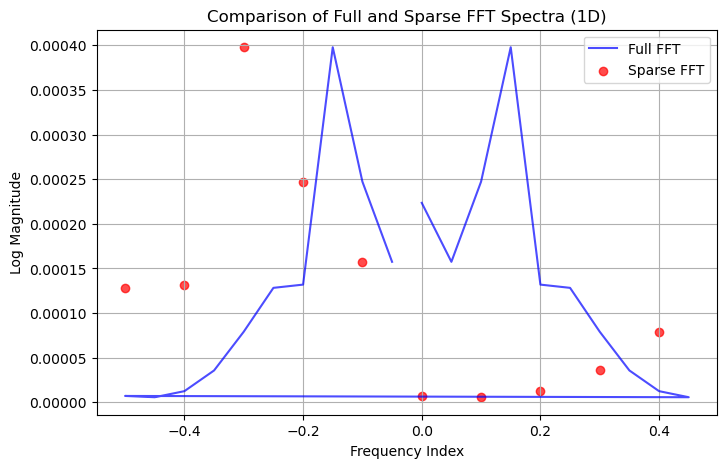

In [24]:
kappa_f1, dominant_freq1, fft_spectrum = MultistageNeuralNetwork.fftn_(x_train, curr_residue)
kappa_f2, dominant_freq2, sparse_spectrum = MultistageNeuralNetwork.sfftn(x_train, curr_residue)
N = int(round(x_train.shape[0] ** (1 / dim)))

# Plot Frequency Spectrum
plt.figure(figsize=(12, 6))

residue_reshape = curr_residue.numpy().reshape([int(round(N_train ** (1 / dim)))] * dim)
full_spectrum = np.fft.fftshift(np.fft.fftn(residue_reshape))
full_spectrum_magnitude = np.log1p(np.abs(full_spectrum))

frequencies_full = np.fft.fftfreq(len(full_spectrum))  # Frequencies for full FFT
frequencies_sparse = np.fft.fftfreq(len(sparse_spectrum))  # Frequencies for sparse FFT

# Compute magnitudes
magnitude_full = np.abs(full_spectrum)
magnitude_sparse = np.abs(sparse_spectrum)

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(frequencies_full, np.log1p(magnitude_full), label="Full FFT", color="blue", alpha=0.7)
plt.scatter(frequencies_sparse, np.log1p(magnitude_sparse), label="Sparse FFT", color="red", marker="o", alpha=0.7)

plt.xlabel("Frequency Index")
plt.ylabel("Log Magnitude")
plt.title("Comparison of Full and Sparse FFT Spectra (1D)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
i = 1
while mean_residue > precision and i < num_stages:
    # kappa, f_d = MultistageNeuralNetwork.fftn_(x_train, curr_residue)
    # if f_d == 0: 
    #     logging.info("Oops! Your dominant frequency is 0...")
    #     break
    kappa = MultistageNeuralNetwork.find_zeros(curr_residue)
    
    # N_train = int(6 * np.pi * f_d)
    # x_train = create_ds(dim, -L/2, L/2, N_train, max_data_size)
    # y_train = tf.reshape(poisson(x_train), [len(x_train), 1])

    print(f"TRAINING STAGE {i + 1}: Data size: {x_train.shape}")

    curr_residue = y_train - tf.add_n([MSNN.stages[j].predict(x_train) for j in range(i)])
    MSNN.train(x_train, curr_residue, stage=i, kappa=kappa, iters=training_iters[i])

    mean_residue = tf.reduce_mean(tf.abs(y_train - tf.add_n([MSNN.stages[j].predict(x_train) for j in range(i)])))
    print(f"Completed training stage {i + 1}, loss={MSNN.stages[i].loss[-1]}, residue={mean_residue}")
    i += 1
if i >= num_stages:
        print(f"Reached maximum stages, loss={MSNN.stages[-1].loss[-1]}, residue={mean_residue}")
elif mean_residue <= precision:
    print(f"Reached threshold precision, loss={MSNN.stages[-1].loss[-1]}, residue={mean_residue}")
else:
    print(f"Exited training unexpectedly, previous loss={MSNN.stages[-2].loss[-1]}, previous residue={mean_residue}")

In [ ]:
loss = np.concatenate([stage.loss for stage in MSNN.stages])
plt.figure()
plt.plot(loss, 'b-')
plt.yscale("log")
plt.title(f"MSNN Dim {dim} Loss Plot")
plt.xlabel("Iterations")
plt.ylabel("Loss")
# plt.savefig(f"plots/MSNN_DIM_{dim}.png")
